# Model calibration and prediction + plots for journal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import math
import pickle
from datetime import datetime
import time
from collections import Counter
import forestci as fci
from sklearn.metrics import mean_squared_error, r2_score
# 内嵌显示图形，而不是弹出单独窗口  简化代码，无需添加plt.show()
%matplotlib inline
import scipy.stats as st
import matplotlib.patches as mpatches

# import functions
from results_plotting_functions import rmspe, alpha_accuracy_beta_rlh, count_entries_per_interval, predict_prob, std_calibrated, calibrated_prob, calibration_isotonic_regression_model


# Select datsets as per Nature NMI - see table in papper for refrence:
1. Group I: full_dataset 
2. Group II: standford_dataset
3.  Group III: oxford_dataset

In [2]:
battery = 'full_dataset'  # specify the group of cells on which to calibrate the model

# Accuracy metrics

# Plotting functions

In [3]:
def plot_results(y_hat, y_test, sem, sem_calibrated, z_value):
    # plot predicted results before and after re-calibration
    '''plotting the confidence interval and the prediction results'''
    x_axis = list(X_test.index.values)
    fig1 = plt.figure(figsize=(10, 10))

    # confidence interval
    
    # plt.errorbar(X_test.Cycle, y_hat, yerr=2 * sem, fmt='o', capsize=3, linewidth=2, ms=2)
    y_up = y_hat + z_value * sem
    y_low = y_hat - z_value * sem
    
    y_up_calibrated = y_hat + z_value * sem_calibrated
    y_low_calibrated = y_hat - z_value * sem_calibrated
    
    # accuracy zone calculationa
    y_acc_zone_up = y_test+alpha_acc_zone*y_test
    y_acc_zone_low = y_test-alpha_acc_zone*y_test


    #calculate predictions in accuracy zone
    acc_zone_entries, beta, rlh = alpha_accuracy_beta_rlh(y_test, y_hat, sem_calibrated, alpha_acc_zone)
    
    
#     plt.fill_between(x_axis, y_low, y_up, color='grey', alpha=0.4)
    plt.plot(x_axis, y_test, 'ro', markersize=4,  alpha=.6, label='True capacity')
#     plt.fill_between(x_axis, y_acc_zone_low, y_acc_zone_up, color='blue', alpha=0.4, label='Accuracy zone [-$\\alpha$, $\\alpha$]')
    
    plt.plot(x_axis, y_hat, 'o', color='k', markersize=4, alpha=.6, label='Predicted capacity')
    plt.fill_between(x_axis, y_low_calibrated, y_up_calibrated, color='orange', alpha=0.4, label='±2$\sigma$')

#     plt.errorbar(x_axis, y_hat, yerr=np.sqrt(V_IJ_unbiased), fmt='o')
    plt.legend(fontsize=20)
    plt.xlabel('Cycle', fontsize=20)
    if battery == 'oxford_dataset':
        plt.ylabel('Capacity [mAh]', fontsize=20)
    else:
        plt.ylabel('Capacity [Ah]', fontsize=20)

    plt.tick_params(axis='both', which='major', labelsize=20)


#     plt.grid(True)
    plt.show()
    
    # calculate accuracy 
    
    r2 = r2_score(y_test, y_hat)
    mape = np.round(np.mean(np.abs((y_test - y_hat) / y_test))*100,2)
    rmspe_calc = np.round(np.mean(np.sqrt(np.mean(np.square(((y_test - y_hat) / y_test)))))*100,2)
    mse = mean_squared_error(y_hat, y_test)
    
    
    print('Accuracy based on $R^2$: {}'.format(r2))
    print('Accuracy based on Mean Absolute Percentage Error: {}'.format(mape))
    print('Accuracy based on Root Mean Squared Percentage Error: {}'.format(rmspe_calc))
    print('Mean Square Error: {}'.format(mse))
    print('% of entriers falling in the accuracy zone: {}'.format(acc_zone_entries)) # note this is percentage
    print('Average probability mass of the prediciton PDF within the accuracy zone: {}'.format(beta))
    print('Ratio of early to late predictions when references to accurazy zone boundries: {}'.format(rlh))

    '''Calculate the calibrations score
       reference: Gaussian process regression for In-situ Capacity Estimation of Lithium-ion Batteries
       Rober R. Richardson, Birkl, Howey
       '''    
    CS = 1/len(X_test) * np.sum((np.abs(y_hat - y_test) < Z * sem))
    CS_calibrated = 1/len(X_test) * np.sum((abs(y_hat - y_test) < Z * sem_calibrated))
    SH = np.mean(sem_calibrated)
    
    print('Calibration score: {}'.format(CS))
    print('Calibration score calibrated model: {}'.format(CS_calibrated))
    print('Sharpness (mean std): {}'.format(SH))
    
    ''' Print the two capacities on the same plot without the cycle number'''
    fig2 = plt.figure(figsize=(10, 10))
    # acc zone display uniformly
    y = np.linspace(np.min(y_test), np.max(y_test), 100)
    y_up = y + alpha_acc_zone*y
    y_low = y - alpha_acc_zone*y
    ax1 = plt.axes()  # standard axes
    ax1.plot(y_test, y_test, 'ro', alpha=.7, zorder=10, label = 'True Capacity ($y^*$)', markersize=2)
    ax1.fill_between(y, y_low, y_up, color='green', alpha=0.6, zorder=10, label='Accuracy zone [-$\\alpha$, $\\alpha$]')
#     ax1.plot(y_test, y_hat, 'o', color='k', alpha=0.6, zorder=10, label='Predicted Capacity')
#     ax1.errorbar(y_test, y_hat, yerr=Z*sem, fmt='--o', color='blue', alpha=0.4, zorder=5, )
    markers, caps, bars = ax1.errorbar(y_test, y_hat, yerr=Z*sem_calibrated, ecolor='orange',capsize=2, capthick=2,
                                       fmt='--o', color='black',alpha=0.6, zorder=5, label='Predicted capacity ($\hat{y}^*$) ±2$\sigma$')

    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    ax1.invert_xaxis()

#     plt.plot(y_test, y_hat, 'o', color='orange', alpha=0.6)
#     plt.gca().invert_xaxis()
    plt.xlabel('True Capacity [Ah]', fontsize=20)
    if battery == 'oxford_dataset':
        plt.ylabel('Capacity [mAh]', fontsize=20)
    else:
        plt.ylabel('Capacity [Ah]', fontsize=20)
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)

#     plt.title('True vs. Predicted Capacity', fontsize=15)
#     plt.grid(True)
    ax2 = plt.axes([0.21, 0.21, 0.24, 0.24])
    percent_error = (y_hat-y_test)/y_test
    no_of_bins = 10 # 50-full_datset, 10 all other datasets
    n, bins, patches = ax2.hist(percent_error, no_of_bins, edgecolor='white', color='black')
    
    for c, p in zip(bins, patches):
        if c >= alpha_acc_zone:
            plt.setp(p, 'facecolor', 'black')
        elif c <= -alpha_acc_zone:
            plt.setp(p, 'facecolor', 'black')
        else:
            plt.setp(p, 'facecolor', 'green') #mediumslateblue
    plt.axvline(0, color='red', linestyle='dashed')#, linewidth=1)
    plt.axvline(-alpha_acc_zone, color='green', linestyle='dashed')#, linewidth=1)
    plt.axvline(alpha_acc_zone, color='green', linestyle='dashed')#, linewidth=1)
    plt.axvline(0, color='red', linestyle='dashed')#, linewidth=1)
    plt.xlabel('% error: $(\hat{y}^*-y^*)/y^*$', fontsize=15)
    plt.ylabel('No. of entries', fontsize=15)
    plt.title('Histogram of % error wrt $\hat{y}^*$', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
#     plt.xlim([-1.2*np.max(abs(y_test-y_hat)), 1.2*np.max(abs(y_test-y_hat))])


    plt.figure(figsize=(10,10))
    plt.plot(abs(y_test-y_hat), sem_calibrated, '*')
    plt.ylabel('Variance')
    plt.xlabel('Error')

#     ax2.text(0.1, .5, r'$-\alpha$')
    
    return fig1, fig2, r2, mape, rmspe_calc, mse, acc_zone_entries, beta, rlh, CS_calibrated, SH

# Load data

In [4]:


# test data
# data_test = pd.read_csv(path + 'data_test_fsed__adversarial' + battery +'.csv', index_col=0)
data_test = pd.read_csv('data_test_fsed.csv', index_col=0)
X_test_complete = data_test.drop(['Discharge_Q', 'Group'], axis=1)
y_test_complete = data_test.Discharge_Q
data_test_4_group = data_test.Group

# load relevant battery dataset for training the algorithm
# if adversarial:
#     data_train = pd.read_csv()
# else:
#     data_train = pd.read_csv()
    
data_train = pd.read_csv('data_train_fsed.csv', index_col=0)

# train data used to train the model
# data_train = pd.read_csv(path + 'data_train_fsed_'+ battery + '.csv', index_col=0)
X_train = data_train.drop(['Discharge_Q', 'Group'], axis=1)
y_train = data_train.Discharge_Q

# re-calibration data


data_calibration = pd.read_csv('data_calibration_fsed.csv', index_col=0)



In [5]:
print('number of Feature selected: \n {}'.format(len(list(X_train))))

number of Feature selected: 
 12


# Expected accuracy


In [6]:
'''
Use +/- alpha accuracy zone as per reference: "On Applying the Prognostics Performance Metrics by Saxena NASA"
'''
alpha_acc_zone = 0.015 # 根据特定领域需求选择how to determine the alpha value - 1.5% is the arbina error, but how to justify the rest?
Z = st.norm.ppf(1-(1-0.9)/2) # calculate z-value for 90% confidence
STD = alpha_acc_zone/Z
var_expected = STD**2
print('期望方差Expected variance based on domain specific selection: {}'.format(var_expected))
print('Z-value used: {}'.format(Z))
"""Z 值（也称为标准分数）表示一个数据点与均值之间的标准差倍数。"""

期望方差Expected variance based on domain specific selection: 8.316258963034389e-05
Z-value used: 1.6448536269514722


'Z 值（也称为标准分数）表示一个数据点与均值之间的标准差倍数。'

In [7]:
'''load models'''
# random forest model
RF_model_filenname = 'RF_model.sav'
RF = pickle.load(open(RF_model_filenname, 'rb'))
RF_model = RF.best_estimator_

# bayesian ridge 
Bayes_Ridge_filename = 'bayesian_ridge_model.sav'
Bayes_Ridge = pickle.load(open(Bayes_Ridge_filename, 'rb'))
Bayes_Ridge_model = Bayes_Ridge.best_estimator_

# Gaussian process model
GPR_model_filenname = 'GPR_model.sav'
GPR = pickle.load(open(GPR_model_filenname, 'rb'))
GPR_model = GPR.best_estimator_

print(type(RF_model))
print(type(GPR_model))
print(type(Bayes_Ridge_model))

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'sklearn.pipeline.Pipeline'>
<class 'sklearn.pipeline.Pipeline'>


In [8]:
# predict with a selected model - HARD CODED

model_name = 'GPR_model' # RF_model, Bayes_Ridge_model, GPR_model
model = GPR_model # RF_model, Bayes_Ridge_model, GPR_model





In [9]:
data_calibration.head()

,Capacity dV CCCT,Charge time dV CCCT,Energy dV CCCT,Entropy dV CCCT Shannon,Frechet Distance CC curve,Hausdorff Distance CC curve,Lagged Cumulated Discharge Capacity,Lagged Cumulated Discharge Energy,Lagged Pseudo Resistace,Lagged cycle time,Mean DV CCCV,Slope CCCV-CCCT,Group,Discharge_Q
0,575.322684,0.004965,575.322684,8.693487,0.846925,6.446099,0.000000,0.000000,0.000000,0.000000,0.480619,18.154890,8004.0,734.075616
1,567.156913,0.004884,567.156913,8.643856,0.846898,6.407781,734.075616,2300.316911,0.025339,0.081895,0.479761,18.447217,8004.0,725.689568
2,562.199427,0.004838,562.199427,8.668885,0.846882,6.394643,1459.765184,4574.211288,0.020326,0.162820,0.479035,18.615078,8004.0,720.520947
3,558.498927,0.004826,558.498927,8.643856,0.846878,6.391274,2180.286131,6833.189439,0.019724,0.243175,0.477944,18.750742,8004.0,716.899385
4,552.993764,0.004780,552.993764,8.622052,0.846862,6.381768,2897.185515,9082.287422,0.020509,0.323102,0.476109,18.831491,8004.0,711.608958


d:\.conda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\.conda\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Calibration done!
------------------------Processing entire dataset--------------------------


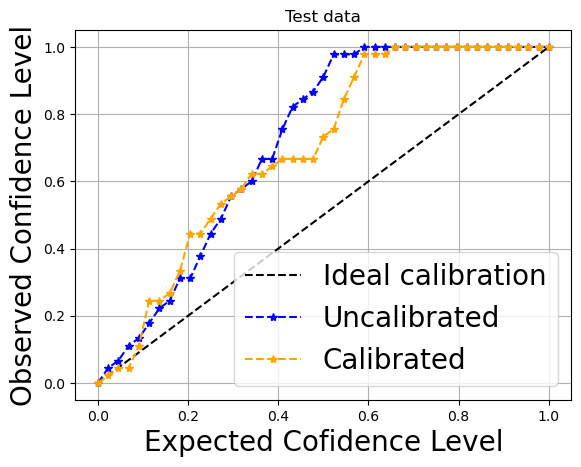

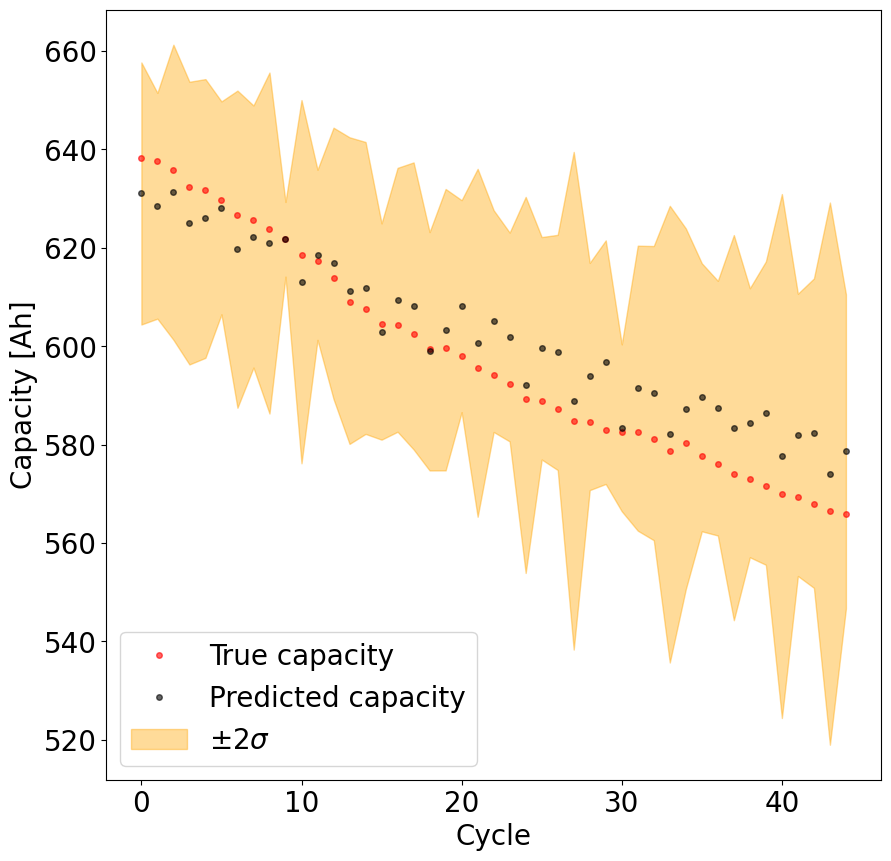

Accuracy based on $R^2$: 0.8656846217257282
Accuracy based on Mean Absolute Percentage Error: 1.18
Accuracy based on Root Mean Squared Percentage Error: 1.38
Mean Square Error: 65.14198227815488
% of entriers falling in the accuracy zone: 0.62
Average probability mass of the prediciton PDF within the accuracy zone: 0.41
Ratio of early to late predictions when references to accurazy zone boundries: 28.888888888888886
Calibration score: 1.0
Calibration score calibrated model: 1.0
Sharpness (mean std): 17.918306797172324
Skipping q=0.1 due to insufficient matches in prob
Skipping q=0.4 due to insufficient matches in prob
Skipping q=0.6 due to insufficient matches in prob
Skipping q=0.9 due to insufficient matches in prob
saved askjahsdkjhsadkashdhasjh
#############################################################################################
Mean accuracy based on $R^2$: 0.8656846217257282
Mean accuracy based on Mean Absolute Percentage Error: 1.18
Mean accuracy based on Root Mean Squar

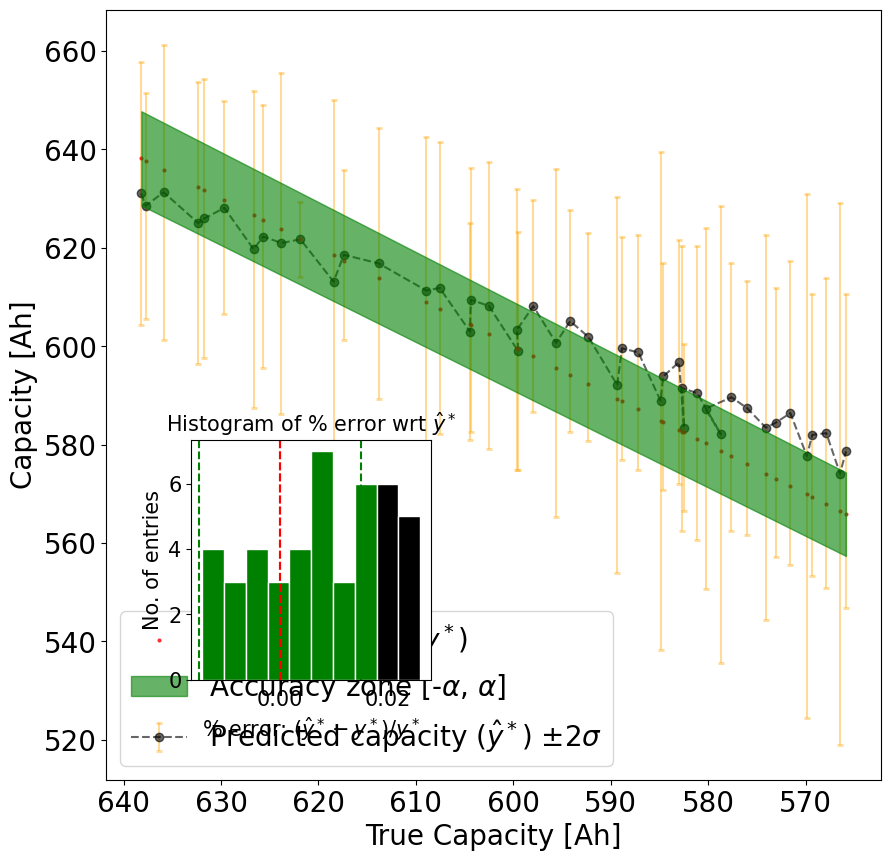

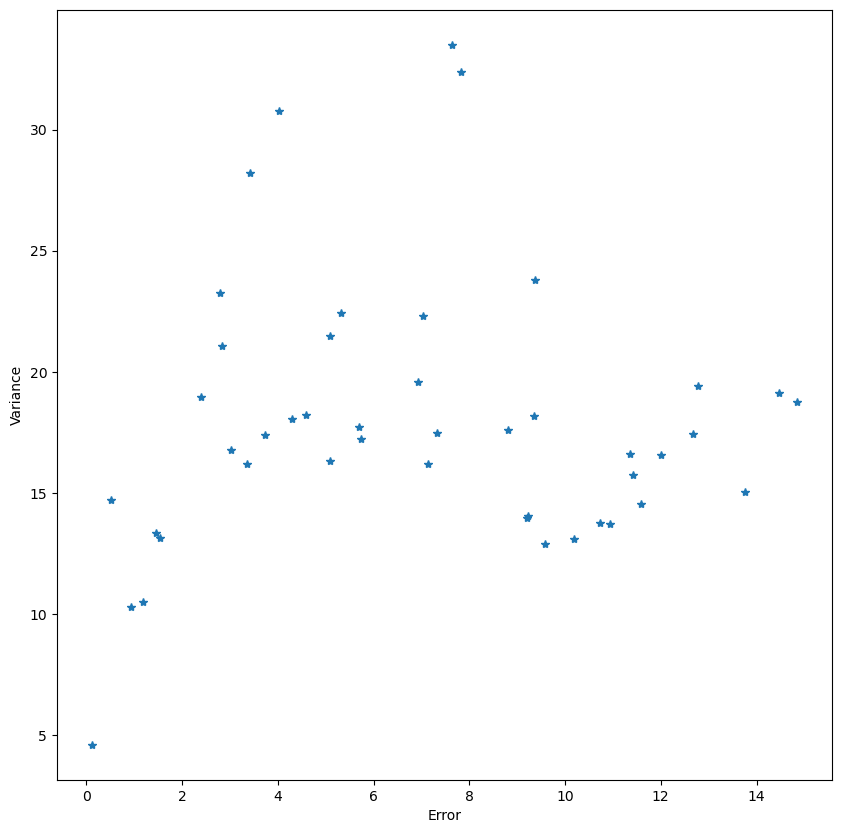

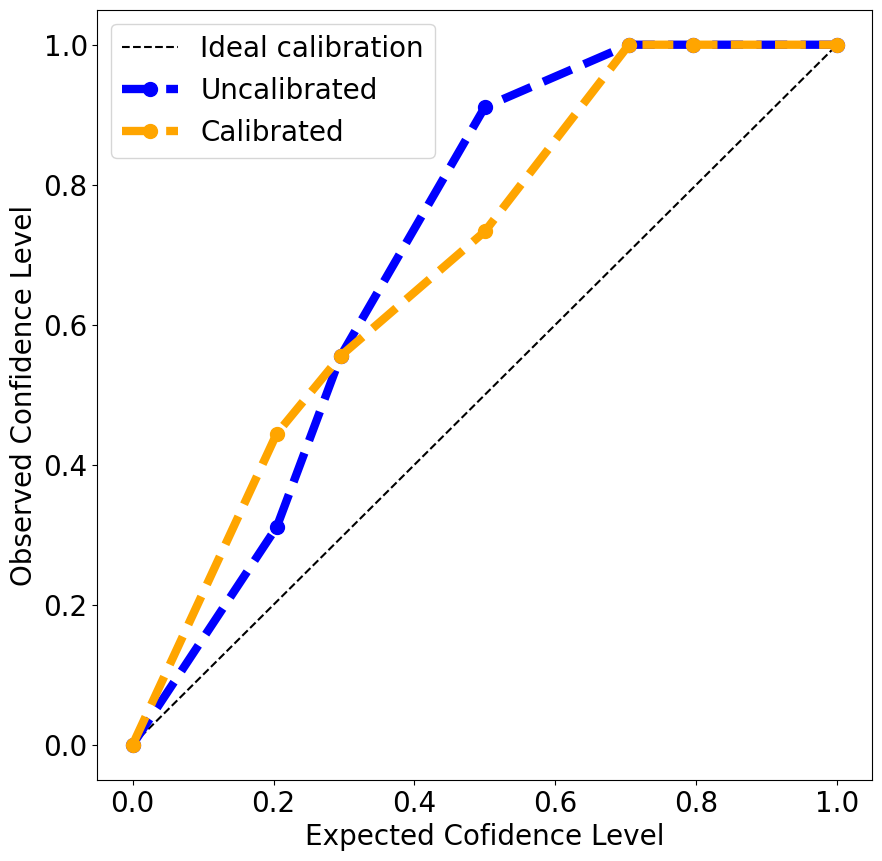

In [10]:


r2_vec = []
mape_vec = []
rmspe_vec = []
mse_vec = []
acc_zone_percentage_vec = []
beta_vec = []
rlh_vec = []
avg_calibration_vec = []
SH_vec = []


X_calibration = data_calibration.drop(['Discharge_Q', 'Group'], axis=1)
y_calibration = data_calibration.Discharge_Q


calibration_model = calibration_isotonic_regression_model(model_name, model, X_calibration, y_calibration, X_train)
print('Calibration done!')


X_test = X_test_complete.reset_index(drop=True)
y_test = y_test_complete.reset_index(drop=True)

if model_name in ['Bayes_Ridge_model', 'GPR_model']:
    y_hat,  sem = model.predict(X_test, return_std=True)
    
elif model_name == 'RF_model':
    y_hat = model.predict(X_test)
    sem = np.sqrt(fci.random_forest_error(RF_model, X_train, X_test))

else:
    y_hat,  sem = model.predict(X_test)

prob_per_int_y_test, prob_y_test, prob_y_test_expected, prob = count_entries_per_interval(y_test, y_hat, sem)
prob_model_y_test = predict_prob(y_test, y_hat, sem)

prob_test_calibrated = calibrated_prob(calibration_model, prob_model_y_test)

sem_calibrated = std_calibrated(y_test, y_hat, prob_test_calibrated)
prob_per_int_y_test_calibrated, prob_y_test_calibrated, prob_y_test_expected, prob = count_entries_per_interval(y_test, y_hat, sem_calibrated)

'''Plotting calibration only'''

# prob_calibration_calibrated = ir.transform(prob_model_y_calibration)
plt.figure()
plt.title('Test data')
plt.plot(prob, prob, 'k--')
plt.plot(prob, prob_per_int_y_test, 'b*--')
plt.plot(prob, prob_per_int_y_test_calibrated, '*--', c='orange')
plt.xlabel('Expected Cofidence Level', fontsize=20)
plt.ylabel('Observed Confidence Level', fontsize=20)
plt.legend(['Ideal calibration', 'Uncalibrated', 'Calibrated'], fontsize=20)
plt.grid(True)


print('------------------------Processing entire dataset--------------------------')
# function to plot the results
fig1, fig2, r2, mape, rmspe, mse, acc_zone_percentage, beta, rlh, CS, SH = plot_results(y_hat, y_test, sem, sem_calibrated, Z)
    
# plot reliability curve for the paper
if r2 < 0 or len(prob)<11: # plot reliability curves for an r2 better greate than 0
    pass
else:
    # note: if there is not suffiecint data in index prob rounding should go to 1
    index = []
    round_value = 2   # <---- for more granularity also changethe round value
    for q in np.round(np.linspace(0, 1, 11), round_value):
        matches = np.where(np.round(prob, round_value) == q)[0]
        if len(matches) > 2:  # 确保有足够的元素
            index.append(matches[2])
        elif len(matches) > 0:  # 如果不足 3 个元素，选择第一个匹配的元素
            index.append(matches[0])
        else:
            print(f"Skipping q={q} due to insufficient matches in prob")
    
    from operator import itemgetter 
    prob_expected = itemgetter(*index)(prob)
    prob_observed_uncalibrated = itemgetter(*index)(prob_per_int_y_test)
    prob_observed_calibrated = itemgetter(*index)(prob_per_int_y_test_calibrated)
    fig3 = plt.figure(figsize=(10,10))
#     plt.title('Test data')
    plt.plot(prob_expected, prob_expected, 'k--', markersize=2)
    plt.plot(prob_expected, prob_observed_uncalibrated, 'bo--', markersize=10, linewidth=6)
    plt.plot(prob_expected, prob_observed_calibrated, 'o--', c='orange', markersize=10, linewidth=6)
    plt.xlabel('Expected Cofidence Level', fontsize=20)
    plt.ylabel('Observed Confidence Level', fontsize=20)
    plt.legend(['Ideal calibration', 'Uncalibrated', 'Calibrated'], fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
#     plt.grid(True) 

#     '''Save figures'''    
print('saved askjahsdkjhsadkashdhasjh')
fig3.savefig(model_name +  "3.pdf", bbox_inches='tight')
fig1.savefig(model_name + "1.pdf", bbox_inches='tight')
fig2.savefig(model_name + "2.pdf", bbox_inches='tight')


# average results
cycles_w_neg_r2 = []
if r2 > 0:
    cycles_w_neg_r2.append(r2)
    
r2_vec.append(r2)
mape_vec.append(mape)
rmspe_vec.append(rmspe)
mse_vec.append(mse)
acc_zone_percentage_vec.append(acc_zone_percentage)
beta_vec.append(beta)
rlh_vec.append(rlh)
avg_calibration_vec.append(CS)
SH_vec.append(SH)

# avergae values across dataset
r2_mean = np.mean(r2_vec)
mape_mean = np.mean(mape_vec)
rmspe_mean = np.mean(rmspe_vec)
mse_mean = np.mean(mse_vec)
acc_zone_percentage_mean = np.mean(acc_zone_percentage_vec)
beta_mean = np.mean(beta_vec)
rlh_mean = np.mean(rlh_vec)
calibration_mean = np.mean(avg_calibration_vec)
SH_mean = np.mean(SH_vec)

print('#############################################################################################')
print('Mean accuracy based on $R^2$: {}'.format(r2_mean))
print('Mean accuracy based on Mean Absolute Percentage Error: {}'.format(mape_mean))
print('Mean accuracy based on Root Mean Squared Percentage Error: {}'.format(rmspe_mean))
print('Mean Mean Square Error: {}'.format(mse_mean))
print('Mean % of entriers falling in the accuracy zone: {}'.format(acc_zone_percentage_mean)) # note this is percentage
print('Mean average probability mass of the prediciton PDF within the accuracy zone: {}'.format(beta_mean))
print('Mean percentage of early predictions when references to accurazy zone boundries: {}'.format(rlh_mean))
print('Mean calibration score calibrated model: {}'.format(calibration_mean))
print('Mean sharpness: {}'.format(SH_mean))
print('#############################################################################################')

 

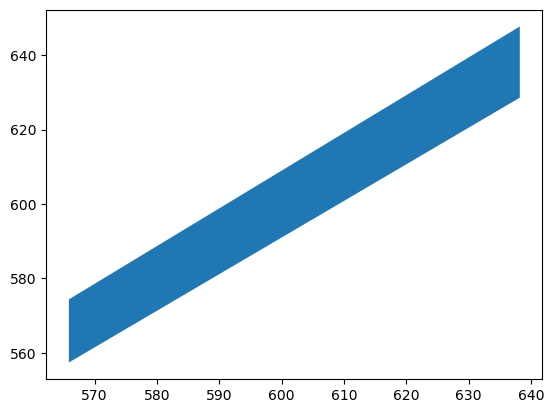

In [11]:

plt.fill_between(y_test, y_test+alpha_acc_zone*y_test , (y_test-alpha_acc_zone*y_test))

